In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.linear import *
import matplotlib.pyplot as plt
import time
import math
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
def test(rounding = "round", abs_err = True):
    ufc_err_min_list = []
    ufc_err_max_list = []
    ufc_err_mean_list = []
    ufc_err_std_list = []
    
    ofc_err_min_list = []
    ofc_err_max_list = []
    ofc_err_mean_list = []
    ofc_err_std_list = []
    
    ifc_err_min_list = []
    ifc_err_max_list = []
    ifc_err_mean_list = []
    ifc_err_std_list = []
    
    x_label = []
    
    for bitwidth in range(6, 13):
        cycle = 2**(bitwidth-1)
        
        in_feature = 2
        out_feature = cycle
        bias = False

        input = torch.cat(2*[(torch.arange(0, out_feature)/out_feature - 0.5).unsqueeze(1)], 1).to(device)
        input[:, 1] = 0.

        fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device)
        fc.weight.data = torch.cat(2*[(torch.arange(0, out_feature)/out_feature - 0.5).unsqueeze(1)], 1).to(device)
        fc.weight.data[:, 1] = 0.
        fc_o = fc(input)

        ufc = HUBLinear(in_feature, out_feature, bias=bias, binary_weight=fc.weight.data, binary_bias=fc.bias, cycle=cycle, rounding=rounding).to(device)
        ufc_o = ufc(input)
        
        if bitwidth % 2 == 0:
            bw_input, bw_wght = (int(bitwidth/2 - 1), int(bitwidth/2 - 1))
        else:
            bw_input, bw_wght = (int((bitwidth+1)/2 - 1), int((bitwidth-1)/2 - 1))
        ofc = FxpLinear(in_feature, out_feature, bias=bias, binary_weight=(fc.weight.data << bw_wght).round() >> bw_wght, binary_bias=fc.bias, bitwidth=(bw_input, bw_wght), keep_res="input", more_res="input", rounding=rounding).to(device)
        ofc_o = ofc((input << bw_input).round() >> bw_input)
#         ofc = FxpLinear(in_feature, out_feature, bias=bias, binary_weight=fc.weight.data, binary_bias=fc.bias, bitwidth=bitwidth, keep_res="output", more_res="input", rounding=rounding).to(device)
#         ofc_o = ofc(input)

        ifc = FxpLinear(in_feature, out_feature, bias=bias, binary_weight=fc.weight.data, binary_bias=fc.bias, bitwidth=bitwidth, keep_res="input",  more_res="input", rounding=rounding).to(device)
        ifc_o = ifc(input)
        
        if abs_err is True:
            ufc_err = (ufc_o - fc_o)
            ofc_err = ofc_o - ((input << bw_input).round() >> bw_input).matmul(((fc.weight.data << bw_wght).round() >> bw_wght).t())
#             ofc_err = (ofc_o - fc_o)
            ifc_err = (ifc_o - fc_o)
        else:
            ufc_err = (ufc_o - fc_o) / fc_o
            ofc_err = (ofc_o - ((input << bw_input).round() >> bw_input).matmul(((fc.weight.data << bw_wght).round() >> bw_wght).t())) / ((input << bw_input).round() >> bw_input).matmul(((fc.weight.data << bw_wght).round() >> bw_wght).t())
#             ofc_err = (ofc_o - fc_o) / fc_o
            ifc_err = (ifc_o - fc_o) / fc_o
        
        ufc_err_min_list.append(np.nanmin(ufc_err.cpu().detach().numpy()))
        ufc_err_max_list.append(np.nanmax(ufc_err.cpu().detach().numpy()))
        ufc_err_mean_list.append(np.nanmean(np.abs(ufc_err.cpu().detach().numpy())))
        ufc_err_std_list.append(np.nanstd(ufc_err.cpu().detach().numpy()))
        
        ofc_err_min_list.append(np.nanmin(ofc_err.cpu().detach().numpy()))
        ofc_err_max_list.append(np.nanmax(ofc_err.cpu().detach().numpy()))
        ofc_err_mean_list.append(np.nanmean(np.abs(ofc_err.cpu().detach().numpy())))
        ofc_err_std_list.append(np.nanstd(ofc_err.cpu().detach().numpy()))
        
        ifc_err_min_list.append(np.nanmin(ifc_err.cpu().detach().numpy()))
        ifc_err_max_list.append(np.nanmax(ifc_err.cpu().detach().numpy()))
        ifc_err_mean_list.append(np.nanmean(np.abs(ifc_err.cpu().detach().numpy())))
        ifc_err_std_list.append(np.nanstd(ifc_err.cpu().detach().numpy()))
        
        x_label.append(2**(bitwidth-1))
    return ufc_err_min_list, ufc_err_max_list, ufc_err_mean_list, ufc_err_std_list, ofc_err_min_list, ofc_err_max_list, ofc_err_mean_list, ofc_err_std_list, ifc_err_min_list, ifc_err_max_list, ifc_err_mean_list, ifc_err_std_list, x_label


In [5]:
rounding = "round"
abs_err = True
ufc_err_min_list, ufc_err_max_list, ufc_err_mean_list, ufc_err_std_list, ofc_err_min_list, ofc_err_max_list, ofc_err_mean_list, ofc_err_std_list, ifc_err_min_list, ifc_err_max_list, ifc_err_mean_list, ifc_err_std_list, x_label = test(rounding, abs_err)
# print(ufc_err_min_list)
# print(ufc_err_max_list)
print(ufc_err_mean_list)
print(ufc_err_std_list)
print()

# print(ofc_err_min_list)
# print(ofc_err_max_list)
print(ofc_err_mean_list)
print(ofc_err_std_list)
print()

# print(ifc_err_min_list)
# print(ifc_err_max_list)
print(ifc_err_mean_list)
print(ifc_err_std_list)
print()

print(x_label)

[0.004585266, 0.0024051666, 0.0012514889, 0.0006483998, 0.00033465342, 0.00017226319, 8.84843e-05]
[0.0059602126, 0.0030687992, 0.0015813288, 0.0008145964, 0.0004191179, 0.00021535733, 0.00011051293]

[0.0146484375, 0.009521484, 0.0038452148, 0.0024261475, 0.0009727478, 0.0006093979, 0.0002439022]
[0.039788183, 0.028466145, 0.013601394, 0.009876326, 0.004686604, 0.0034446358, 0.0016287657]

[0.0, 0.0, 5.3481077e-09, 5.3392415e-09, 5.3415232e-09, 5.342861e-09, 5.3433906e-09]
[0.0, 0.0, 7.1853523e-09, 7.171389e-09, 7.174263e-09, 7.175663e-09, 7.1761006e-09]

[32, 64, 128, 256, 512, 1024, 2048]


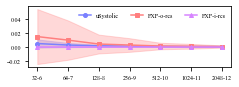

In [6]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

font = {'family':'Times New Roman', 'size': 6}

matplotlib.rc('font', **font)

my_dpi = 300
fig_h = 1.2
fig_w = 3.3115

# construct some data like what you have:
x = np.array([i for i in range(len(ufc_err_mean_list))])
means1 = np.array(ufc_err_mean_list)
stds1 = np.array(ufc_err_std_list)
mins1 = np.array(ufc_err_min_list)
maxs1 = np.array(ufc_err_max_list)

means2 = np.array(ofc_err_mean_list)
stds2 = np.array(ofc_err_std_list)
mins2 = np.array(ofc_err_min_list)
maxs2 = np.array(ofc_err_max_list)

means3 = np.array(ifc_err_mean_list)
stds3 = np.array(ifc_err_std_list)
mins3 = np.array(ifc_err_min_list)
maxs3 = np.array(ifc_err_max_list)

x_label = ['32-6', '64-7', '128-8', '256-9', '512-10', '1024-11', '2048-12']

width = 0.20
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# ax.bar(x-width, means1, width, yerr=stds1, align='center', alpha=1, capsize=3, color="#7A81FF", label="uSystolic")
# ax.bar(x,       means2, width, yerr=stds2, align='center', alpha=1, capsize=3, color="#FF7F7F", label="FXP-o")
# ax.bar(x+width, means3, width, yerr=stds3, align='center', alpha=1, capsize=3, color="#D783FF", label="FXP-i")


# ax.errorbar(x-width, means1, yerr=stds1, capsize=3, color="#7A81FF", label="uSystolic", fmt="-o", xuplims=True)
# ax.errorbar(x,       means2, yerr=stds2, capsize=3, color="#FF7F7F", label="FXP-o", fmt="-x", xuplims=True)
# ax.errorbar(x+width, means3, yerr=stds3, capsize=3, color="#D783FF", label="FXP-i", fmt="-*", xuplims=True)

ax.plot(x, means1, "-o", label="uSystolic", color="#7A81FF", ms=4)
ax.fill_between(x, means1-stds1, means1+stds1, alpha=0.3, color="#7A81FF", edgecolor="face")

ax.plot(x, means2, "-s", label="FXP-o-res", color="#FF7F7F", ms=4)
ax.fill_between(x, means2-stds2, means2+stds2, alpha=0.3, color="#FF7F7F", edgecolor="face")

ax.plot(x, means3, "-^", label="FXP-i-res", color="#D783FF", ms=4)
ax.fill_between(x, means3-stds3, means3+stds3, alpha=0.3, color="#D783FF", edgecolor="face")

ax.set_xticks(x)
ax.set_xticklabels(x_label)
ax.set_yscale('linear')
# ax.set_ylim(0, 0.99)
# ax.set_yticks([0, 10**(-7), 10**(-5), 10**(-3), 10**(-1)])
# ax.set_yticklabels(["0", "1e-7", "1e-5", "1e-3", "1e-1"])
ax.legend(loc="upper right", ncol=3, frameon=False)

fig.tight_layout()
plt.show()
fig.savefig("test_kernel_linear_fxp_hub_compare_abs_err.pdf", bbox_inches='tight', dpi=my_dpi)


In [7]:
rounding = "round"
abs_err = False
ufc_err_min_list, ufc_err_max_list, ufc_err_mean_list, ufc_err_std_list, ofc_err_min_list, ofc_err_max_list, ofc_err_mean_list, ofc_err_std_list, ifc_err_min_list, ifc_err_max_list, ifc_err_mean_list, ifc_err_std_list, x_label = test(rounding, abs_err)
# print(ufc_err_min_list)
# print(ufc_err_max_list)
print(ufc_err_mean_list)
print(ufc_err_std_list)
print()

# print(ofc_err_min_list)
# print(ofc_err_max_list)
print(ofc_err_mean_list)
print(ofc_err_std_list)
print()

# print(ifc_err_min_list)
# print(ifc_err_max_list)
print(ifc_err_mean_list)
print(ifc_err_std_list)
print()

print(x_label)

[0.22314043, 0.15113735, 0.098801814, 0.06270332, 0.038817663, 0.023544908, 0.014040932]
[0.33889717, 0.28093427, 0.22531737, 0.1764278, 0.13570829, 0.10300284, 0.077395834]

[0.1663516, 0.101740815, 0.035711385, 0.02204627, 0.008333297, 0.0051758843, 0.0020161285]
[0.24733381, 0.19420241, 0.089881286, 0.06795174, 0.031635746, 0.023759754, 0.011126143]

[0.0, 0.0, 8.598326e-08, 8.582412e-08, 8.5841116e-08, 8.5867875e-08, 8.588988e-08]
[0.0, 0.0, 1.7066903e-08, 1.7001721e-08, 1.6994415e-08, 1.699605e-08, 1.699902e-08]

[32, 64, 128, 256, 512, 1024, 2048]


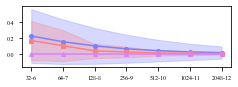

In [8]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

font = {'family':'Times New Roman', 'size': 6}

matplotlib.rc('font', **font)

my_dpi = 300
fig_h = 1.2
fig_w = 3.3115

# construct some data like what you have:
x = np.array([i for i in range(len(ufc_err_mean_list))])
means1 = np.array(ufc_err_mean_list)
stds1 = np.array(ufc_err_std_list)
mins1 = np.array(ufc_err_min_list)
maxs1 = np.array(ufc_err_max_list)

means2 = np.array(ofc_err_mean_list)
stds2 = np.array(ofc_err_std_list)
mins2 = np.array(ofc_err_min_list)
maxs2 = np.array(ofc_err_max_list)

means3 = np.array(ifc_err_mean_list)
stds3 = np.array(ifc_err_std_list)
mins3 = np.array(ifc_err_min_list)
maxs3 = np.array(ifc_err_max_list)

x_label = ['32-6', '64-7', '128-8', '256-9', '512-10', '1024-11', '2048-12']

width = 0.20
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

# ax.bar(x-width, means1, width, yerr=stds1, align='center', alpha=1, capsize=3, color="#7A81FF", label="uSystolic")
# ax.bar(x,       means2, width, yerr=stds2, align='center', alpha=1, capsize=3, color="#FF7F7F", label="FXP-o")
# ax.bar(x+width, means3, width, yerr=stds3, align='center', alpha=1, capsize=3, color="#D783FF", label="FXP-i")


# ax.errorbar(x-width, means1, yerr=stds1, capsize=3, color="#7A81FF", label="uSystolic", fmt="-o", xuplims=True)
# ax.errorbar(x,       means2, yerr=stds2, capsize=3, color="#FF7F7F", label="FXP-o", fmt="-x", xuplims=True)
# ax.errorbar(x+width, means3, yerr=stds3, capsize=3, color="#D783FF", label="FXP-i", fmt="-*", xuplims=True)

ax.plot(x, means1, "-o", label="uSystolic", color="#7A81FF", ms=4)
ax.fill_between(x, means1-stds1, means1+stds1, alpha=0.3, color="#7A81FF", edgecolor="face")

ax.plot(x, means2, "-s", label="FXP-o-res", color="#FF7F7F", ms=4)
ax.fill_between(x, means2-stds2, means2+stds2, alpha=0.3, color="#FF7F7F", edgecolor="face")

ax.plot(x, means3, "-^", label="FXP-i-res", color="#D783FF", ms=4)
ax.fill_between(x, means3-stds3, means3+stds3, alpha=0.3, color="#D783FF", edgecolor="face")

ax.set_xticks(x)
ax.set_xticklabels(x_label)
ax.set_yscale('linear')
# ax.set_ylim(0, 0.99)
# ax.set_yticks([0, 10**(-7), 10**(-5), 10**(-3), 10**(-1)])
# ax.set_yticklabels(["0", "1e-7", "1e-5", "1e-3", "1e-1"])
# ax.legend(loc="upper right", ncol=3, frameon=False)

fig.tight_layout()
plt.show()
fig.savefig("test_kernel_linear_fxp_hub_compare_rel_err.pdf", bbox_inches='tight', dpi=my_dpi)
